In [1]:
import pandas as pd
import numpy as np
import csv
import glob
import os
import psycopg2 as pg
import datetime as dt

%matplotlib inline

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
# Connecting to Postgres database

conn = pg.connect("dbname=retrosheet user=danielgoodman") #connect and return connection
cur = conn.cursor()
source_table = 'ejections2' # Name of table in retrosheet database

SQL_base = """SELECT
        *
    FROM 
        {source_table}
    
    ;"""
SQL_base = SQL_base.format(source_table=source_table)

test_query = pd.read_sql_query(SQL_base, conn) 
test_query.head()

,game_id_ej,game_date_ej,home_team_id_ej,inn_ct_ej,bat_home_id_ej,bat_id_ej,pitch_seq_tx_ej,event_tx_ej,ej_code,ejectee,job_code,ump_id,reason
0,ANA200004240,2000-04-24,ANA,9,True,kenna001,FBFX,3(B)3(1)/LDP,ej,madlb001,C,welkb901,Balls and strikes
1,ANA200004240,2000-04-24,ANA,2,False,polol001,X,46(1)/FO,ej,mansd801,C,culbf901,Call at 2B (Bumped umpire)
2,ANA200004240,2000-04-24,ANA,5,True,glaut001,CCX,63/G,ej,garnp001,M,welkb901,Balls and strikes
3,ANA200005100,2000-05-10,ANA,3,True,salmt001,BBX,63/G,ej,hatcm001,C,clara901,Fan interference call
4,ANA200007040,2000-07-04,ANA,3,False,hendr001,CCFC,K/C,ej,hendr001,P,welkb901,Called third strike


In [3]:
t = test_query
t.head()

,game_id_ej,game_date_ej,home_team_id_ej,inn_ct_ej,bat_home_id_ej,bat_id_ej,pitch_seq_tx_ej,event_tx_ej,ej_code,ejectee,job_code,ump_id,reason
0,ANA200004240,2000-04-24,ANA,9,True,kenna001,FBFX,3(B)3(1)/LDP,ej,madlb001,C,welkb901,Balls and strikes
1,ANA200004240,2000-04-24,ANA,2,False,polol001,X,46(1)/FO,ej,mansd801,C,culbf901,Call at 2B (Bumped umpire)
2,ANA200004240,2000-04-24,ANA,5,True,glaut001,CCX,63/G,ej,garnp001,M,welkb901,Balls and strikes
3,ANA200005100,2000-05-10,ANA,3,True,salmt001,BBX,63/G,ej,hatcm001,C,clara901,Fan interference call
4,ANA200007040,2000-07-04,ANA,3,False,hendr001,CCFC,K/C,ej,hendr001,P,welkb901,Called third strike


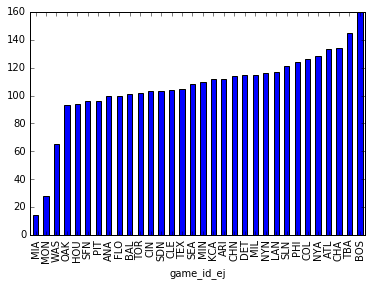

In [4]:
# Plot of total ejections by team
t.groupby(t.game_id_ej.str[:3]).size().sort_values().plot(kind='bar')

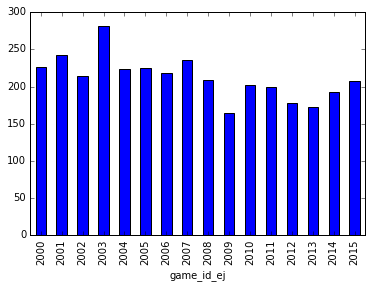

In [5]:
# Plot of number of total ejections per year

# Fix with .dt.year

t.groupby(t.game_id_ej.str[3:7]).size().plot(kind='bar') # 2003 had the most ejections
#t.groupby(t.game_id_ej.dt.year).size().plot(kind='bar') # 2003 had the most ejections

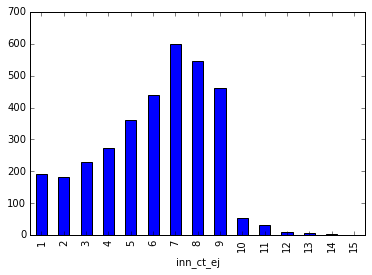

In [6]:
# Plot of ejections grouped by inning 

t.groupby(t.inn_ct_ej).size().plot(kind='bar') # Most ejections occurred in the 7th inning, nearly 600.

In [7]:
# List of top 10 umpires for most ejections
t.groupby(t.ump_id).size().sort_values(ascending=False).head(10)

ump_id
fostm901    83
westj901    79
welkb901    76
timmt901    75
eddid901    74
drakr901    65
iassd901    65
gibsg901    64
wendh902    63
cuzzp901    62
dtype: int64

In [8]:
# Total ejections by job code
t.groupby(t.job_code).size().sort_values(ascending=False)

job_code
P    1634
M    1434
C     316
N       4
dtype: int64

In [9]:
# Top 10 reasons for someone getting ejected
t.groupby(t.reason).size().sort_values(ascending=False).head(20)

reason
Balls and strikes                     893
Called third strike                   484
Intentional HBP                       290
Call at 1B                            212
Checked swing                         124
Call at HP                             84
Call at 2B                             74
Fair/foul call                         45
Call at 3B                             42
Balk call                              40
Throwing at batter                     38
Replay ruling                          36
Fighting                               21
Check swing                            21
Bench jockeying                        20
Interference call                      19
Bench-clearing brawl                   15
Balls and strikes (while catching)     15
Brawl                                  14
Balk non-call                          12
dtype: int64

In [10]:
# Examples of 5 teams that had one ejection in the game
s = t[t.game_id_ej.isin(t.game_id_ej.value_counts().tail().index)]
s

,game_id_ej,game_date_ej,home_team_id_ej,inn_ct_ej,bat_home_id_ej,bat_id_ej,pitch_seq_tx_ej,event_tx_ej,ej_code,ejectee,job_code,ump_id,reason
4,ANA200007040,2000-07-04,ANA,3,False,hendr001,CCFC,K/C,ej,hendr001,P,welkb901,Called third strike
1277,FLO200506120,2005-06-12,FLO,9,True,lodup001,.BFCFC,K,ej,lodup001,P,drakr901,Called third strike
1504,KCA200607050,2006-07-05,KCA,7,False,puntn001,BBS1>T,SB2,ej,bellb001,M,hallt901,Arguing for foul ball
2045,SFN200807180,2008-07-18,SFN,5,False,braur002,X,T7/F,ej,bochb002,M,wolfj901,Call at 3B
2205,SDN200905200,2009-05-20,SDN,8,True,ecksd001,.BCX,E5/TH1,ej,bochb002,M,cedeg901,Call at 1B


In [ ]:
# For each game with an ejection, compare the average number of runs the team has allowed before an ejection
# with the average number of runs a team scores after an ejection. 
# Do the same with runs allowed. 

In [11]:
source_table = 'event'

SQL_query = """SELECT
        *
    FROM 
        {source_table} ev
    LEFT JOIN
        ejections2 ej
    ON ej.game_id_ej = ev.game_id
        AND ej.inn_ct_ej = ev.inn_ct
        AND ej.bat_id_ej = ev.bat_id
        AND ej.pitch_seq_tx_ej = ev.pitch_seq_tx
        AND ej.event_tx_ej = ev.event_tx
    WHERE
        ev.game_id in ('ANA200007040', 'FLO200506120', 'KCA200607050', 'ANA200004030')
    ;"""
SQL_query = SQL_query.format(source_table=source_table)

ej_query = pd.read_sql_query(SQL_query, conn)
    

In [12]:
source_table = 'event'

SQL_query = """SELECT
        *
    FROM 
        {source_table} ev
    LEFT JOIN
        ejections2 ej
    ON ej.game_id_ej = ev.game_id
        AND ej.inn_ct_ej = ev.inn_ct
        AND ej.bat_id_ej = ev.bat_id
        AND ej.pitch_seq_tx_ej = ev.pitch_seq_tx
        AND ej.event_tx_ej = ev.event_tx
    WHERE
        ev.game_year = 2015
    AND 
        ev.home_team_id = 'SFN'
    ;"""
SQL_query = SQL_query.format(source_table=source_table)

full_query = pd.read_sql_query(SQL_query, conn)
    

In [13]:
SFN2015_df = full_query.copy()
SFN2015_df = SFN2015_df.drop(SFN2015_df.columns[-13:-5], axis=1)
SFN2015_df.head()
len(SFN2015_df)

6200

In [14]:
ej1 = ej_query.copy()
ej1.head()

,event_uid,game_id,game_date,game_year,game_month,game_day_of_month,game_number,home_team_id,away_team_id,inn_ct,...,inn_ct_ej,bat_home_id_ej,bat_id_ej,pitch_seq_tx_ej,event_tx_ej,ej_code,ejectee,job_code,ump_id,reason
0,ANA200004030001,ANA200004030,2000-04-03,2000,4,3,0,ANA,NYA,1,...,NaN,None,None,None,None,None,None,None,None,None
1,ANA200004030002,ANA200004030,2000-04-03,2000,4,3,0,ANA,NYA,1,...,NaN,None,None,None,None,None,None,None,None,None
2,ANA200004030003,ANA200004030,2000-04-03,2000,4,3,0,ANA,NYA,1,...,NaN,None,None,None,None,None,None,None,None,None
3,ANA200004030004,ANA200004030,2000-04-03,2000,4,3,0,ANA,NYA,1,...,NaN,None,None,None,None,None,None,None,None,None
4,ANA200004030005,ANA200004030,2000-04-03,2000,4,3,0,ANA,NYA,1,...,NaN,None,None,None,None,None,None,None,None,None


In [15]:
ej2 = ej_query.copy()
ej2 = ej2.drop(ej2.columns[-13:-5], axis=1)
ej2.head()

,event_uid,game_id,game_date,game_year,game_month,game_day_of_month,game_number,home_team_id,away_team_id,inn_ct,...,ass2_fld_cd,ass3_fld_cd,ass4_fld_cd,ass5_fld_cd,event_id,ej_code,ejectee,job_code,ump_id,reason
0,ANA200004030001,ANA200004030,2000-04-03,2000,4,3,0,ANA,NYA,1,...,0,0,0,0,1,None,None,None,None,None
1,ANA200004030002,ANA200004030,2000-04-03,2000,4,3,0,ANA,NYA,1,...,0,0,0,0,2,None,None,None,None,None
2,ANA200004030003,ANA200004030,2000-04-03,2000,4,3,0,ANA,NYA,1,...,0,0,0,0,3,None,None,None,None,None
3,ANA200004030004,ANA200004030,2000-04-03,2000,4,3,0,ANA,NYA,1,...,0,0,0,0,4,None,None,None,None,None
4,ANA200004030005,ANA200004030,2000-04-03,2000,4,3,0,ANA,NYA,1,...,0,0,0,0,5,None,None,None,None,None


In [16]:
source_table = 'ejections2'

SQL_query = """SELECT
        game_id_ej
    FROM 
        {source_table} 
    ;"""
SQL_query = SQL_query.format(source_table=source_table)

ej_game_list_query = pd.read_sql_query(SQL_query, conn)

In [17]:
ej_game_list = ej_game_list_query
'ANA200004240' in list(ej_game_list.game_id_ej)

True

In [18]:
sf = SFN2015_df.copy()

sf.sort_values(['game_id', 'event_id'], ascending=[True, True])


,event_uid,game_id,game_date,game_year,game_month,game_day_of_month,game_number,home_team_id,away_team_id,inn_ct,...,ass2_fld_cd,ass3_fld_cd,ass4_fld_cd,ass5_fld_cd,event_id,ej_code,ejectee,job_code,ump_id,reason
5995,SFN201504130001,SFN201504130,2015-04-13,2015,4,13,0,SFN,COL,1,...,0,0,0,0,1,None,None,None,None,None
5994,SFN201504130002,SFN201504130,2015-04-13,2015,4,13,0,SFN,COL,1,...,6,0,0,0,2,None,None,None,None,None
5993,SFN201504130003,SFN201504130,2015-04-13,2015,4,13,0,SFN,COL,1,...,0,0,0,0,3,None,None,None,None,None
5992,SFN201504130004,SFN201504130,2015-04-13,2015,4,13,0,SFN,COL,1,...,0,0,0,0,4,None,None,None,None,None
5991,SFN201504130005,SFN201504130,2015-04-13,2015,4,13,0,SFN,COL,1,...,0,0,0,0,5,None,None,None,None,None
5990,SFN201504130006,SFN201504130,2015-04-13,2015,4,13,0,SFN,COL,1,...,0,0,0,0,6,None,None,None,None,None
5989,SFN201504130007,SFN201504130,2015-04-13,2015,4,13,0,SFN,COL,1,...,0,0,0,0,7,None,None,None,None,None
5988,SFN201504130008,SFN201504130,2015-04-13,2015,4,13,0,SFN,COL,1,...,0,0,0,0,8,None,None,None,None,None
5987,SFN201504130009,SFN201504130,2015-04-13,2015,4,13,0,SFN,COL,1,...,0,0,0,0,9,None,None,None,None,None
5986,SFN201504130010,SFN201504130,2015-04-13,2015,4,13,0,SFN,COL,2,...,0,0,0,0,10,None,None,None,None,None


In [19]:
seen = set()

for game, row in SFN2015_df.set_index('game_id').sort_index().iterrows():
    game = row['game_id']
    if game in seen: # Already seen this game
        continue
    else: # Not yet seen this game
        seen.add(game)
        print game
        
    #for index, row in SFN2015_df.set_index('game_id').iterrows():
    #        print "\t", row['event_uid']
#    for game in SFN2015_df.index:
#        print game

KeyError: 'game_id'

In [83]:
# Modified to use SFN2015_df instead of ej2. Remember to change back for testing.

games = []
seen = set()

g = SFN2015_df.groupby([SFN2015_df.home_team_id, SFN2015_df.game_id])['event_id'].max()
h = SFN2015_df.groupby([SFN2015_df.home_team_id, SFN2015_df.game_id])['ej_code'].max()

# Loop through rows in the dataframe
for index, row in SFN2015_df.sort_values(['game_id', 'event_id'], ascending=[True, True]).iterrows(): 

    # Loop through each game
    ##while game == 
    # 1. Game has an ejection?
    if row['game_id'] in list(ej_game_list.game_id_ej): # Game has an ejection in it
        print "\nEjection in game ", row['game_id']
        print "\n", row['event_uid']
    
        # 2. Find ej_code == 'ej' row, use to take "pre" scores
        if row['ej_code'] == 'ej': # Ejection row
            print "\n Home score pre-ejection is ", row['home_score_ct']
            games.append(
                {
                'team':row['home_team_id'],
                'game_id':row['game_id'],
                'has_ej':'yes', #FIXME
                'hscore_pre':row['home_score_ct']
                }
            )
            print "\n Away score pre-ejection is ", row['away_score_ct']
            games.append(
                {
                'team':row['home_team_id'],
                'game_id':row['game_id'],
                'has_ej':'yes', #FIXME
                'ascore_pre':row['away_score_ct']
                }
            )
        
        # 3. Find last record of game, use to take "post" scores
        else: # Not an ejection row 
            if row['event_id'] == g.loc[row['home_team_id'], row['game_id']]: # Last record, get "post" scores
                print "\n Home score at end of game is ", row['home_score_ct']
                games.append(
                    {
                    'team':row['home_team_id'],
                    'game_id':row['game_id'],
                    'has_ej':'yes', #FIXME
                    'hscore_post':row['home_score_ct']
                    }
                )
                print "\n Away score at end of game is ", row['away_score_ct']
                games.append(
                    {
                    'team':row['home_team_id'],
                    'game_id':row['game_id'],
                    'has_ej':'yes', #FIXME
                    'ascore_post':row['away_score_ct']
                    }
                )
    
    # 4. Game does not have an ejection?
    else: # Game does not have any ejections in it
        print "\nNo ejection in game ", row['game_id']
        print "\n", row['event_uid']
    
        if row['event_id'] == g.loc[row['home_team_id'], row['game_id']]: # Last record, get "post" scores
            print "\n Home score at end of game is ", row['home_score_ct']
            print "\n Away score at end of game is ", row['away_score_ct']
            games.append(
                {
                'team':row['home_team_id'],
                'game_id':row['game_id'],
                'has_ej':'no',
                'hscore_pre':None,
                'ascore_pre':None,
                'hscore_post':row['home_score_ct'],
                'ascore_post':row['away_score_ct']
                }
            )


No ejection in game  SFN201504130

SFN201504130001

No ejection in game  SFN201504130

SFN201504130002

No ejection in game  SFN201504130

SFN201504130003

No ejection in game  SFN201504130

SFN201504130004

No ejection in game  SFN201504130

SFN201504130005

No ejection in game  SFN201504130

SFN201504130006

No ejection in game  SFN201504130

SFN201504130007

No ejection in game  SFN201504130

SFN201504130008

No ejection in game  SFN201504130

SFN201504130009

No ejection in game  SFN201504130

SFN201504130010

No ejection in game  SFN201504130

SFN201504130011

No ejection in game  SFN201504130

SFN201504130012

No ejection in game  SFN201504130

SFN201504130013

No ejection in game  SFN201504130

SFN201504130014

No ejection in game  SFN201504130

SFN201504130015

No ejection in game  SFN201504130

SFN201504130016

No ejection in game  SFN201504130

SFN201504130017

No ejection in game  SFN201504130

SFN201504130018

No ejection in game  SFN201504130

SFN201504130019

No ejection

ValueError: I/O operation on closed file

In [84]:
len(games)

24

In [86]:
# Remove duplicate dictionaries

seen = set()
games_new = []
for game in games:
    t = tuple(game.items())
    if t not in seen:
        seen.add(t)
        games_new.append(game)

print len(games_new)

#if not any(d['main_color'] == 'red' for d in a):
    # does not exist


24


In [88]:
test_df = pd.DataFrame(games_new)
cols = test_df.columns.tolist()
cols = [cols[6], cols[2], cols[3], cols[5], cols[1], cols[4], cols[0]]
test_df = test_df[cols]
test_df[test_df.has_ej == 'yes'].groupby('game_id').size()#.game_id

#FIXME Add other indices into the dictionary appends (in the previous step)

Series([], dtype: int64)

In [89]:
SFN2015_df[SFN2015_df.ej_code == 'ej'].sort('game_date')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,event_uid,game_id,game_date,game_year,game_month,game_day_of_month,game_number,home_team_id,away_team_id,inn_ct,...,ass2_fld_cd,ass3_fld_cd,ass4_fld_cd,ass5_fld_cd,event_id,ej_code,ejectee,job_code,ump_id,reason
3473,SFN201506160063,SFN201506160,2015-06-16,2015,6,16,0,SFN,SEA,8,...,0,0,0,0,63,ej,bochb001,M,hirsj901,Balls and strikes
3474,SFN201506160063,SFN201506160,2015-06-16,2015,6,16,0,SFN,SEA,8,...,0,0,0,0,63,ej,pagaa001,P,hirsj901,Balls and strikes
3405,SFN201506230057,SFN201506230,2015-06-23,2015,6,23,0,SFN,SDN,8,...,0,0,0,0,57,ej,kempm001,P,reynj901,Checked swing
3406,SFN201506230057,SFN201506230,2015-06-23,2015,6,23,0,SFN,SDN,8,...,0,0,0,0,57,ej,murpp801,M,culbf901,Checked swing
1991,SFN201508150025,SFN201508150,2015-08-15,2015,8,15,0,SFN,WAS,3,...,0,0,0,0,25,ej,mccas001,C,blasc901,Balls and strikes


In [90]:
test_df.groupby([test_df.team, test_df.has_ej, test_df.game_id]) \
['hscore_pre', 'ascore_pre', 'hscore_post', 'ascore_post'].max()
#test_df.groupby([test_df.team, test_df.has_ej]).size()

# YES! Worked beautifully!

hscore_pre  ascore_pre  hscore_post  ascore_post
team has_ej game_id                                                       
SFN  no     SFN201504130         NaN         NaN            0            2
            SFN201504140         NaN         NaN            1            4
            SFN201504150         NaN         NaN            2            4
            SFN201504160         NaN         NaN            6            7
            SFN201504170         NaN         NaN            0            9
            SFN201504180         NaN         NaN            4            1
            SFN201504190         NaN         NaN            1            5
            SFN201504210         NaN         NaN            6            2
            SFN201504220         NaN         NaN            2            2
            SFN201504230         NaN         NaN            2            2
            SFN201505010         NaN         NaN            2            2
            SFN201505020         NaN         NaN            5            4
            SFN201505030         NaN         NaN            5            0
            SFN201505040         NaN         NaN            2            0
            SFN201505050         NaN         NaN            6            0
            SFN201505060         NaN         NaN            1            9
            SFN201505070         NaN         NaN            2            7
            SFN201505080         NaN         NaN            6            0
            SFN201505090         NaN         NaN            2            6
            SFN201505100         NaN         NaN            2            2
            SFN201505190         NaN         NaN            2            0
            SFN201505200         NaN         NaN            4            0
            SFN201505210         NaN         NaN            4            0
            SFN201505280         NaN         NaN            7            0

In [43]:
h = full_df.groupby([full_df.home_team_id, full_df.game_id])['ej_code'].max()
#if row['ej_code'] == h.loc[row['home_team_id'], row['game_id']]: # It's a game with an ejection in it
h.loc['TOR', 'TOR201506080']

'ej'

In [ ]:
g = full_df.groupby([full_df.home_team_id, full_df.game_id])['event_id'].max()
if row['event_id'] == g.loc[row['home_team_id'], row['game_id']]: # Last record of that game, get "post" scores
        

In [86]:
print 'ascore_pre: ', test_df.groupby('game_id')['ascore_pre'].max()
print ''
print 'ascore_post: ', test_df.groupby('game_id')['ascore_post'].max()
print ''
print 'hscore_pre: ', test_df.groupby('game_id')['hscore_pre'].max()
print ''
print 'hscore_post: ', test_df.groupby('game_id')['hscore_post'].max()

ascore_pre:  game_id
ANA200007040    1.0
FLO200506120    6.0
KCA200607050    3.0
Name: ascore_pre, dtype: float64

ascore_post:  game_id
ANA200007040    6.0
FLO200506120    6.0
KCA200607050    3.0
Name: ascore_post, dtype: float64

hscore_pre:  game_id
ANA200007040    3.0
FLO200506120    2.0
KCA200607050    3.0
Name: hscore_pre, dtype: float64

hscore_post:  game_id
ANA200007040    7.0
FLO200506120    2.0
KCA200607050    6.0
Name: hscore_post, dtype: float64


In [ ]:
## ==> Start analysis again from here

In [81]:
g = ej2.groupby([ej2.home_team_id, ej2.game_id])['event_id'].max()

g.loc['ANA', 'ANA200007040']

75

In [66]:
ej2.groupby([ej2.home_team_id, ej2.ej_code.fillna('None')])['away_score_ct'].max()


home_team_id  ej_code
ANA           None       6
              ej         1
FLO           None       6
              ej         6
KCA           None       3
              ej         3
Name: away_score_ct, dtype: int64

In [51]:
g = ej2.groupby([ej2.home_team_id, ej2.ej_code.fillna('None')])['away_score_ct'].max()
g

home_team_id  ej_code
ANA           None       6
              ej         1
FLO           None       6
              ej         6
KCA           None       3
              ej         3
Name: away_score_ct, dtype: int64

In [15]:
ej1 = ej_query

hscore_pre = ej2[ej2.ej_code == 'ej']['home_score_ct'].values.max() # Score before the ejection in this one game, kinda
hscore_pre

3

In [16]:
ascore_pre = ej2[ej2.ej_code == 'ej']['away_score_ct'].values.max()
ascore_pre

6

In [17]:
hscore_post = ej2[ej2.ej_code != 'ej']['home_score_ct'].values.max() # Score after the ejection in this one game, kinda
hscore_post

7

In [18]:
ascore_post = ej2[ej2.ej_code != 'ej']['away_score_ct'].values.max() 
ascore_post

6

In [19]:
games = []

for index, row in ej2.iterrows():
    hscore_pre = -1
    hscore_post = -1
    ascore_pre = -1
    ascore_post = -1
    
    if row['ej_code'] == 'ej': # Ejection record: use this row to take "pre" scores
        if row['bat_home_id'] == True: # Home team batting
            hscore_pre = row['home_score_ct']
            print hscore_pre
            games.append(
                {
                    'game_id':row['game_id'][0],
                    'hscore_pre':hscore_pre
                }
            )
        else: # Away team batting
            ascore_pre = row['away_score_ct']
            print ascore_pre
            games.append(
                {
                    'game_id':row['game_id'][0],
                    'ascore_pre':ascore_pre
                }
            )
    else: # Not an ejection record: use this row to take "post" scores 
        if row['bat_home_id'] == True: # Home team batting
            hscore_post = row['home_score_ct']
            print hscore_post
            games.append(
                {
                    'game_id':row['game_id'][0],
                    'hscore_post':hscore_post
                }
            )
        else: # Away team batting
            ascore_post = row['away_score_ct']
            print ascore_post
            games.append(
                {
                    'game_id':row['game_id'][0],
                    'ascore_post':ascore_post
                }
            )
print games        
        
    #games.append(
    #   {
     #       'game_id':row['game_id'],
            
        #for row['game_id'] in ej1['game_id']: # loop through each game
        #print row['game_id']

        #if row['bat_home_id'].any() == True: # Home team batting
        #if row['ej_code'] == 'ej':
        #    ascore_pre = row['away_score_ct'].values.max()
        #    print ascore_pre
    
        #print "Home team runs scored pre-ejection: ", row['home_score_ct']
        #print "\nHome team runs scored post-ejection: ", hscore_post
        #else: # Away team batting
        #print "Away team runs scored pre-ejection: ", ascore_pre
        #print "\nAway team runs scored post-ejection: ", ascore_post
        #print row

0
0
0
1
0
0
0
1
1
1
1
1
1
1
1
3
3
3
3
1
1
1
3
3
3
1
1
1
3
3
3
4
1
1
1
4
4
4
1
1
1
1
2
2
4
4
5
5
4
4
4
4
4
4
5
5
5
5
5
6
5
5
5
5
6
6
6
5
5
5
7
7
6
6
6
0
0
0
0
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
2
2
3
2
2
2
3
3
3
2
2
2
2
2
3
3
3
4
4
4
4
2
2
2
4
4
4
2
2
2
4
4
4
4
6
2
2
2
6
6
6
2
2
2
0
0
0
0
0
0
0
1
1
0
0
0
1
1
1
1
0
0
0
0
0
1
1
1
3
1
2
2
1
1
1
1
2
2
2
2
3
3
3
1
1
1
1
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
6
3
3
6
6
6
3
3
3
[{'game_id': 'A', 'ascore_post': 0}, {'game_id': 'A', 'ascore_post': 0}, {'game_id': 'A', 'ascore_post': 0}, {'game_id': 'A', 'ascore_post': 1}, {'hscore_post': 0, 'game_id': 'A'}, {'hscore_post': 0, 'game_id': 'A'}, {'hscore_post': 0, 'game_id': 'A'}, {'hscore_post': 1, 'game_id': 'A'}, {'game_id': 'A', 'ascore_post': 1}, {'game_id': 'A', 'ascore_post': 1}, {'game_id': 'A', 'ascore_post': 1}, {'game_id': 'A', 'ascore_post': 1}, {'hscore_post': 1, 'game_id': 'A'}, {'hscore_post': 1, 'game_id': 'A'}, {'hscore_post': 1, 'game_id': '

In [20]:
test_df = pd.DataFrame(games)
test_df

,ascore_post,ascore_pre,game_id,hscore_post,hscore_pre
0,0.0,NaN,A,NaN,NaN
1,0.0,NaN,A,NaN,NaN
2,0.0,NaN,A,NaN,NaN
3,1.0,NaN,A,NaN,NaN
4,NaN,NaN,A,0.0,NaN
5,NaN,NaN,A,0.0,NaN
6,NaN,NaN,A,0.0,NaN
7,NaN,NaN,A,1.0,NaN
8,1.0,NaN,A,NaN,NaN
9,1.0,NaN,A,NaN,NaN


In [83]:
print 'ascore_pre: ', test_df.groupby('game_id')['ascore_pre'].max()
print ''
print 'ascore_post: ', test_df.groupby('game_id')['ascore_post'].max()
print ''
print 'hscore_pre: ', test_df.groupby('game_id')['hscore_pre'].max()
print ''
print 'hscore_post: ', test_df.groupby('game_id')['hscore_post'].max()

ascore_pre:  game_id
ANA200007040    1.0
FLO200506120    NaN
KCA200607050    3.0
Name: ascore_pre, dtype: float64

ascore_post:  game_id
ANA200007040    6.0
FLO200506120    6.0
KCA200607050    3.0
Name: ascore_post, dtype: float64

hscore_pre:  game_id
ANA200007040    NaN
FLO200506120    2.0
KCA200607050    NaN
Name: hscore_pre, dtype: float64

hscore_post:  game_id
ANA200007040    7.0
FLO200506120    2.0
KCA200607050    6.0
Name: hscore_post, dtype: float64


In [56]:
for index, row in ej1.iterrows():
    print row['game_id'][0]
    if row['ej_code'] == 'ej': # Ejection record: use this row to take "pre" scores
        print "\nEjection in game ", row['game_id'][0]
        print "\n Home score pre-ejection is ", row['home_score_ct']
        print "\n Away score pre-ejection is ", row['away_score_ct']
    else: # Not an ejection row: use this row to take "post" scores 
        # if event_id is max for that game_id

ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040

Ejection in game  ANA200007040

 Home score pre-ejection is  3

 Away score pre-ejection is  1
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA200007040
ANA2000

In [106]:
list(ej1.columns)
#ej1.groupby('home_team_id').size()

['event_uid',
 'game_id',
 'game_date',
 'game_year',
 'game_month',
 'game_day_of_month',
 'game_number',
 'home_team_id',
 'away_team_id',
 'inn_ct',
 'bat_home_id',
 'half_inning_id',
 'outs_ct',
 'balls_ct',
 'strikes_ct',
 'pitch_seq_tx',
 'away_score_ct',
 'home_score_ct',
 'runs',
 'bat_id',
 'bat_hand_cd',
 'resp_bat_id',
 'resp_bat_hand_cd',
 'pit_id',
 'pit_hand_cd',
 'resp_pit_id',
 'resp_pit_hand_cd',
 'pos2_fld_id',
 'pos3_fld_id',
 'pos4_fld_id',
 'pos5_fld_id',
 'pos6_fld_id',
 'pos7_fld_id',
 'pos8_fld_id',
 'pos9_fld_id',
 'base1_run_id',
 'base2_run_id',
 'base3_run_id',
 'event_tx',
 'leadoff_fl',
 'ph_fl',
 'bat_fld_cd',
 'bat_lineup_id',
 'event_cd',
 'bat_event_fl',
 'ab_fl',
 'h_fl',
 'sh_fl',
 'sf_fl',
 'event_outs_ct',
 'dp_fl',
 'tp_fl',
 'rbi_ct',
 'wp_fl',
 'pb_fl',
 'fld_cd',
 'battedball_cd',
 'bunt_fl',
 'foul_fl',
 'battedball_loc_tx',
 'err_ct',
 'err1_fld_cd',
 'err1_cd',
 'err2_fld_cd',
 'err2_cd',
 'err3_fld_cd',
 'err3_cd',
 'bat_dest_id',
 'run1_de

In [ ]:
# where game_id in [x,y,z]:
# loop over game, filter down to ej_code == 'ej'

# ej1 
# loop over df, pull max score per game for home/away team pre (when ej_code == 'ej' and post ejection = whole game), 
# put into dictionary: game_id:{prescore, postscore} , dictionary of dictionaries
#make play_id, look up hash tables 

# *** groupby game_id --> max of home/away score

# df1 = ej rows, df2 = last row of each game --> filter command, put max by game_id
# look into dictionary/list comprehension

# temp talbe, sql runs aggregations for means

In [ ]:
# loop over index

In [ ]:
#ejections_scores = [
#    {},
#    {},
#    {},
#    {},
#    {},
#   {}
#    ]

In [ ]:
all_stuff = []
for game_id in list():
    item = {game_ide
           prescore,
           postscore
           ...}
    all_stuff.append(item)

all_stuff --> df
    

In [189]:
for index, row in ej1[ej1.ej_code == 'ej'].iterrows():
    print row['home_team_id']
    print row['bat_home_id']
    #.max()#.values#max()

home_team_id    ANA
home_team_id    ANA
Name: 20, dtype: object
bat_home_id    False
bat_home_id    False
Name: 20, dtype: object


In [151]:
bat_home = ej1[ej1.ej_code == 'ej']['bat_home_id'].values.max() 

if bat_home == True: # Home team batting
    print "Home team runs scored pre-ejection: ", hscore_pre
    print "\nHome team runs scored post-ejection: ", hscore_post
else: # Away team batting
    print "Away team runs scored pre-ejection: ", ascore_pre
    print "\nAway team runs scored post-ejection: ", ascore_post

Away team runs scored pre-ejection:  1

Away team runs scored post-ejection:  6


In [153]:
ej1[ej1.ej_code == 'ej']

,event_uid,game_id,game_date,game_year,game_month,game_day_of_month,game_number,home_team_id,away_team_id,inn_ct,...,inn_ct,bat_home_id,bat_id,pitch_seq_tx,event_tx,ej_code,ejectee,job_code,ump_id,reason
20,ANA200007040021,ANA200007040,2000-07-04,2000,7,4,0,ANA,SEA,3,...,3.0,False,hendr001,CCFC,K/C,ej,hendr001,P,welkb901,Called third strike


In [ ]:
# 1. Upload code - jupyter notebooks and data processing/SQL files - to GitHub
# 2. Come up with questions for Alex
#    - How to compute sum(score) before/after the ejection?
#    - How to join datasets in best fashion?

In [ ]:
### TO DO ###

# Create table of names of coaches, managers, players and umpires with their ID codes
# Need to clean up/consolidate a lot of reason codings
# Replace missing data
# Table with player performance stats, like batting avg, ERA, slash line, etc.?